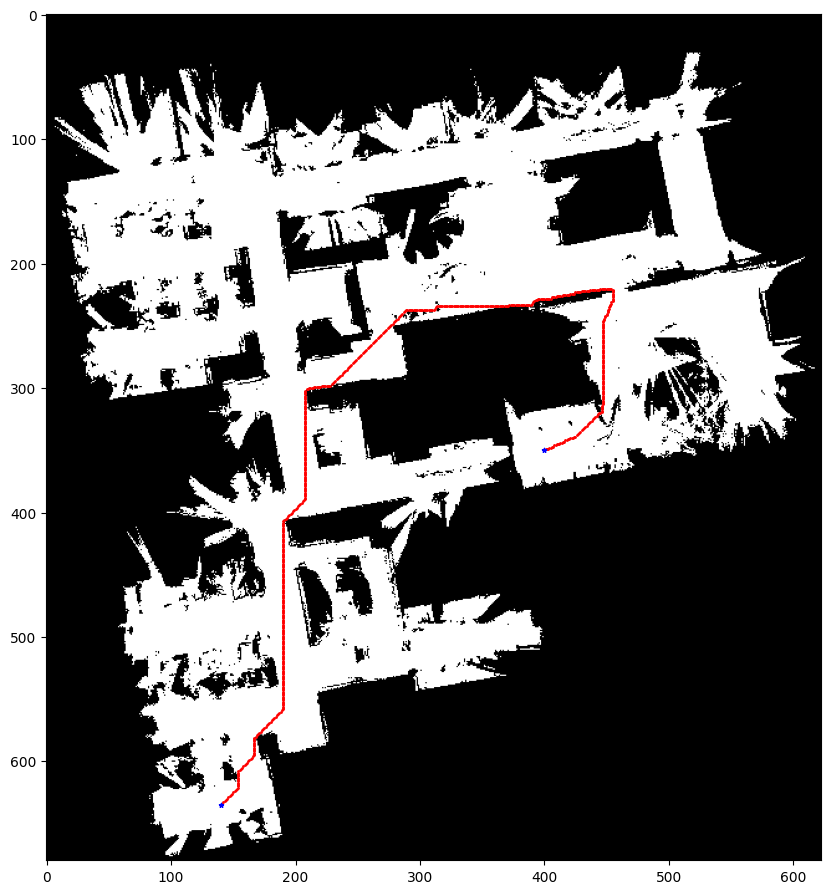

In [15]:
from heapq import heappush, heappop
import numpy as np
from PIL import Image
import itertools
import matplotlib.pyplot as plt


class PriorityQueue:
    # Class made from Python heapq documentation
    REMOVED = "<removed-vertex>"  # placeholder for a removed vertex

    def __init__(self):
        self.pq = []  # list of entries arranged in a heap
        self.entry_finder = {}  # mapping of vertexs to entries
        self.counter = itertools.count()  # unique sequence count

    def add_vertex(self, vertex, priority):
        "Add a new vertex or update the priority of an existing vertex"
        if vertex in self.entry_finder:
            self.remove_vertex(vertex)
        count = next(self.counter)
        entry = [priority, count, vertex]
        self.entry_finder[vertex] = entry
        heappush(self.pq, entry)

    def remove_vertex(self, vertex):
        "Mark an existing vertex as REMOVED.  Raise KeyError if not found."
        entry = self.entry_finder.pop(vertex)
        entry[-1] = PriorityQueue.REMOVED

    def pop_vertex(self):
        "Remove and return the lowest priority vertex. Raise KeyError if empty."
        while self.pq:
            _, _, vertex = heappop(self.pq)
            if vertex is not PriorityQueue.REMOVED:
                del self.entry_finder[vertex]
                return vertex
        raise KeyError("pop from an empty priority queue")


def N(v, M):
    row_start = max(0, v[0] - 1)
    col_start = max(0, v[1] - 1)

    ROI = M[
        row_start : min(M.shape[0] + 1, v[0] + 2),
        col_start : min(M.shape[1] + 1, v[1] + 2),
    ]

    return [(row_start + pt[0], col_start + pt[1]) for pt in np.argwhere(ROI)]


def d(v1, v2):
    return np.sqrt((v1[0] - v2[0]) ** 2 + (v1[1] - v2[1]) ** 2)


def RecoverPath(s, g, pred):
    # start and goal are tuples (r,c), pred is dict
    vertex_curr = g
    opt_path = [g]
    while not vertex_curr == s:
        vertex_curr = pred[vertex_curr]
        opt_path.append(vertex_curr)
        
    return opt_path[::-1]


def a_star_search(V, s, g, N, w, h):
    # N is neighbors function
    # h is estimated cost from s to g
    # w is weight function

    CostTo = {}
    EstTotalCost = {}
    pred = {}
    Q = PriorityQueue()

    CostTo = {v: np.inf for v in np.ndindex(*V.shape)}
    EstTotalCost = CostTo.copy()

    CostTo[s] = 0
    EstTotalCost[s] = h(s, g)

    Q.add_vertex(s, h(s, g))

    while Q.pq:
        v = Q.pop_vertex()
        if v == g:
            return RecoverPath(s, g, pred)

        for i in N(v, V):
            pvi = CostTo[v] + w(v, i)
            if pvi < CostTo[i]:
                pred[i] = v
                CostTo[i] = pvi
                EstTotalCost[i] = pvi + h(i, g)
                Q.add_vertex(i, EstTotalCost[i])

    return None


# Run a*
occupancy_map_img = Image.open("occupancy_map.png")
occupancy_grid = (np.asarray(occupancy_map_img) > 0).astype(int)

s = (635, 140)
g = (350, 400)

shortest_path = a_star_search(occupancy_grid, s, g, N, d, d)
path_to_scatter = np.asarray(shortest_path)

fig = plt.figure(figsize=(10,12))
plt.imshow(occupancy_map_img, cmap="gray")
plt.scatter(path_to_scatter[1:-1,1], path_to_scatter[1:-1,0], c='r', s=1)
plt.scatter(path_to_scatter[[0,-1],1], path_to_scatter[[0,-1],0], c='b', s=10, marker="*")
plt.show()


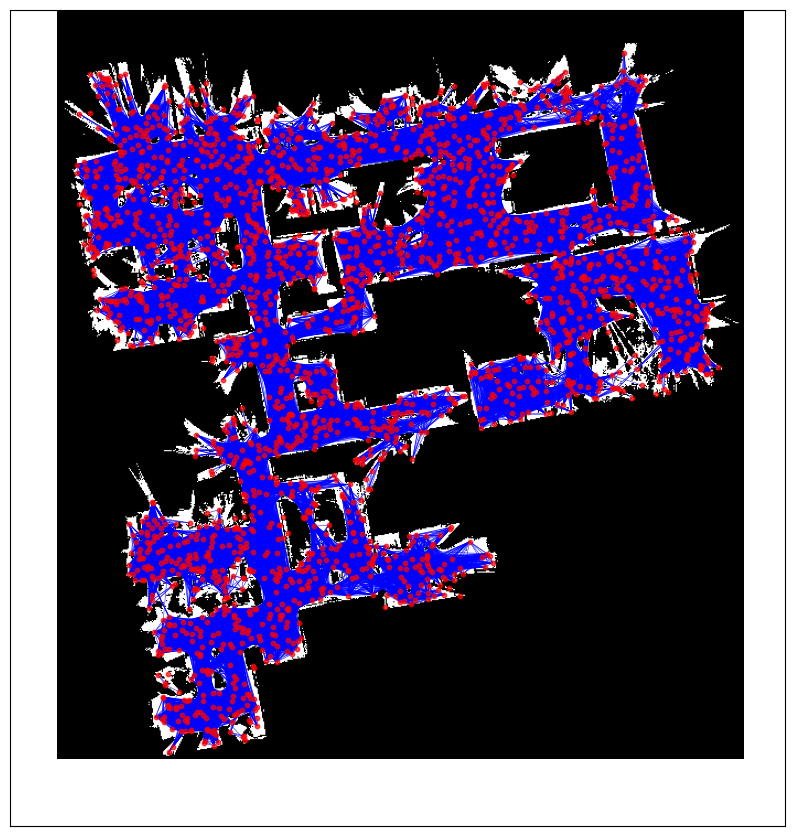

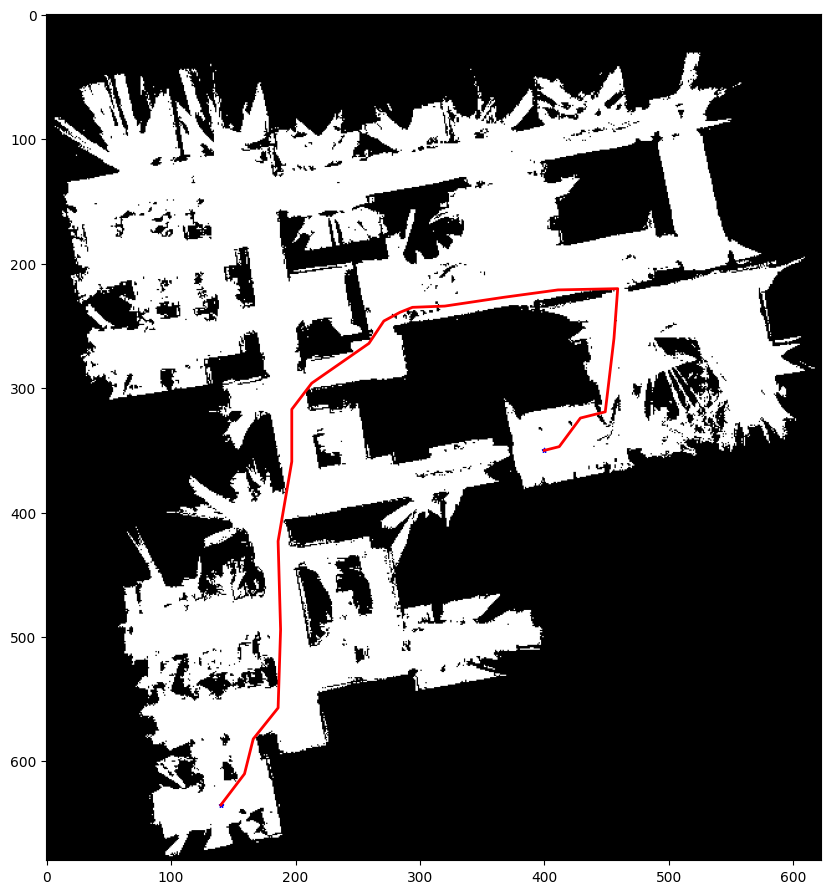

In [ ]:
import networkx as nx


def sample_new_vertex(M):
    rng = np.random.default_rng()
    n_rows = M.shape[0]
    n_cols = M.shape[1]

    r = rng.integers(0, n_rows)
    c = rng.integers(0, n_cols)

    while not M[r, c]:
        r = rng.integers(0, n_rows)
        c = rng.integers(0, n_cols)

    return (r, c)


def is_reachable(v1, v2, M):
    # Shouldn't be comparing identical points, but this would be true nonetheless
    if v1 == v2:
        return True

    # Split
    x1 = v1[1]
    y1 = v1[0]
    x2 = v2[1]
    y2 = v2[0]

    # Path is vertical
    if x1 == x2:
        return all(M[min(y1, y2) : max(y1, y2) + 1, x1])

    # Path is horizontal
    if y1 == y2:
        return all(M[y1, min(x1, x2) : max(x1, x2) + 1])

    # Bresenham algorithm
    dx = abs(x2 - x1)
    sx = 1 if x1 < x2 else -1
    dy = -abs(y2 - y1)
    sy = 1 if y1 < y2 else -1
    error = dx + dy
    while True:
        if not M[y1, x1]:
            return False
        e2 = 2 * error
        if e2 >= dy:
            if x1 == x2:
                break
            error = error + dy
            x1 = x1 + sx
        if e2 <= dx:
            if y1 == y2:
                break
            error = error + dx
            y1 = y1 + sy
    return True


def addVertex(G, v, dmax, M):
    G.add_node(v)
    for node in G.nodes():
        if node != v:
            dist = d(v, node)
            if dist <= dmax and is_reachable(v, node, M):
                G.add_edge(v, node, weight=dist)

    return G


def constructPRM(M, N, dmax):
    G = nx.Graph()
    for _ in range(N):
        v = sample_new_vertex(M)
        G = addVertex(G, v, dmax, M)
    return G


# Run
occupancy_map_img = Image.open("occupancy_map.png")
occupancy_grid = (np.asarray(occupancy_map_img) > 0).astype(int)

N = 2500
dmax = 75

OG = constructPRM(occupancy_grid, N, dmax)

fig = plt.figure(figsize=(10, 12))
plt.imshow(occupancy_map_img, cmap="gray")

pos = {node: (node[1], node[0]) for node in OG.nodes()}

nx.draw_networkx(
    OG,
    pos=pos,
    node_size=10,
    node_color="red",
    edge_color="blue",
    width=0.5,
    with_labels=False,
    alpha=0.7,
)

OG = addVertex(OG, s, dmax, occupancy_grid)
OG = addVertex(OG, g, dmax, occupancy_grid)

while not nx.has_path(OG, s, g):
    v = sample_new_vertex(occupancy_grid)
    OG = addVertex(OG, v, dmax, occupancy_grid)

path = np.asarray(nx.astar_path(OG, s, g))

fig = plt.figure(figsize=(10, 12))
plt.imshow(occupancy_map_img, cmap="gray")
plt.plot(path[:, 1], path[:, 0], c="r", linewidth=2)
plt.scatter(path[[0, -1], 1], path[[0, -1], 0], c="b", s=10, marker="*")